# preprocess
1. convert rda file into h5ad (see Rscript) 
2. load h5ad and metadata
3. QC (mitochondria / ribosome / doublet / HVGs)
4. cluster
5. mapmycell - currently using the web version 

## 1. convert `.rda` file to python readable
- refer script `rds2h5_allsnRNAdata.R`

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

Duplicate key in file PosixPath('/home/shuonan.chen/miniconda3/envs/allensdk/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 271 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')


## 2. load the actual raw counts from H5ad
- original file location is `/allen/programs/celltypes/workgroups/rnaseqanalysis/10x/v4/10xV4_Pilot/Neuromodulatory_Noradrenergic/10xV4_Neuromodulatory_Noradrenergic_complete_RTX-4134_mat_241111.rda` 
- but its convered into h5ad in `~/scratch_shuonan/LC_scRNAseq/conversion_files/snRNAseq_LCNE_ALLCELLS.h5ad`

### a. count data from h5ad

In [ ]:
rawfilename = '/home/shuonan.chen/scratch_shuonan/LC_scRNAseq/conversion_files/snRNAseq_LCNE_ALLCELLS.h5ad'
raw_adata = sc.read_h5ad(rawfilename)
raw_adata.shape

### b. meta data from csv 

In [ ]:
metadatafile = '/home/shuonan.chen/scratch_shuonan/LC_scRNAseq/conversion_files/snRNAseq_LCNE_ALLCELLS_metadata.csv'
metadata = pd.read_csv(metadatafile)
metadata.shape

## 3. preprocessings, QCs. 

### a. find mitochondria/ribosome RNAs

In [43]:
raw_adata.var["mt"] = raw_adata.var_names.str.startswith("mt-")
raw_adata.var["ribo"] = raw_adata.var_names.str.startswith(("Rps", "Rpl")) # no Mt
sc.pp.calculate_qc_metrics(raw_adata, qc_vars=["mt", "ribo"], percent_top=None, log1p=False, inplace=True)

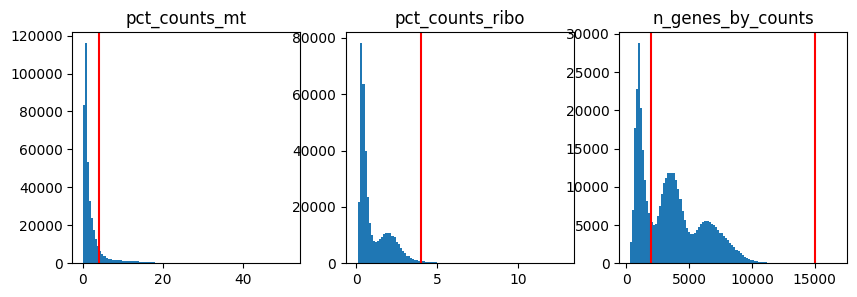

In [44]:
mt_thre = 4
ribo_thre = 4
totalcounts_thre = (2000,15000)

plt.figure(figsize = (10,3))
plt.subplot(1,3,1);
plt.hist(raw_adata.obs['pct_counts_mt'].values.flatten(), bins = 100);
plt.axvline(mt_thre, color = 'red')
plt.title('pct_counts_mt')

plt.subplot(1,3,2);
plt.hist(raw_adata.obs['pct_counts_ribo'].values.flatten(), bins = 100);
plt.axvline(ribo_thre, color = 'red')
plt.title('pct_counts_ribo')

plt.subplot(1,3,3);
plt.hist(raw_adata.obs['n_genes_by_counts'].values.flatten(), bins = 100);
plt.axvline(totalcounts_thre[0], color = 'red');
plt.axvline(totalcounts_thre[1], color = 'red')
plt.title('n_genes_by_counts');

In [45]:
mask = (
    (raw_adata.obs['pct_counts_mt'] < mt_thre) &
    (raw_adata.obs['pct_counts_ribo'] < ribo_thre) &
    (raw_adata.obs['n_genes_by_counts'].between(totalcounts_thre[0], totalcounts_thre[1])))

filtered_adata_0 = raw_adata[mask].copy()
filtered_metadata_0 = metadata[mask.values].copy()
print("Cells before filtering:", raw_adata.n_obs)
print("Cells after filtering:", filtered_adata_0.n_obs)


Cells before filtering: 398912
Cells after filtering: 251611


### b. doublet score check

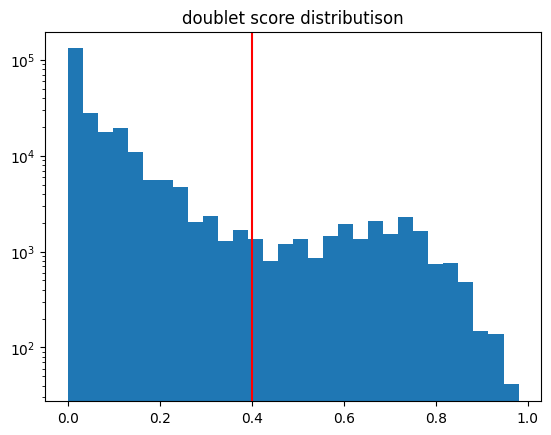

In [46]:
doublet_thre = 0.4
plt.hist(filtered_metadata_0['doublet_score'].values, bins =30);
plt.title('doublet score distributison');
plt.axvline(doublet_thre, color = 'r'); # this is what yoh used
plt.yscale('log')

In [47]:
(filtered_metadata_0['sample_id']==filtered_adata_0.obs.index).sum()

251611

In [48]:
filtered_adata = filtered_adata_0[filtered_metadata_0['doublet_score'].values<doublet_thre]
filtered_metadata = filtered_metadata_0[filtered_metadata_0['doublet_score'].values<doublet_thre]

print("Cells before doublet score filtering:", filtered_adata_0.n_obs)
print("Cells after doublet score filtering:", filtered_adata.n_obs)


Cells before doublet score filtering: 251611
Cells after doublet score filtering: 231474


In [49]:
filtered_metadata = filtered_metadata.set_index("sample_id")
filtered_metadata = filtered_metadata.reindex(filtered_adata.obs_names)
filtered_adata.obs = pd.concat([filtered_adata.obs, filtered_metadata.iloc[:,16:]], axis=1)

In [50]:
def fill_na_obs(adata):
    obs = adata.obs.copy()
    for c in obs.columns:
        obs[c] = obs[c].astype(object).where(~obs[c].isna(), "not_available")
    adata.obs = obs
    return adata

filtered_adata = fill_na_obs(filtered_adata)

### c. HVGs

In [52]:
N_HVG, NPCA = 1500, 30
sc.pp.highly_variable_genes(filtered_adata, n_top_genes=N_HVG, flavor="seurat_v3")
sc.pp.normalize_total(filtered_adata, target_sum=1e4)
sc.pp.log1p(filtered_adata)

filtered_adata = filtered_adata[:, filtered_adata.var["highly_variable"]].copy()
sc.pp.scale(filtered_adata, zero_center=True, max_value=10)
sc.tl.pca(filtered_adata, n_comps=NPCA, svd_solver="arpack")

In [53]:

def two_stage_harmony(adata, batch_key="batch", amp_key="rna_amplification"):
    # ensure columns exist
    if batch_key not in adata.obs.columns:
        for alt in ["batch_vendor_name","RTX","file_col"]:
            if alt in adata.obs.columns:
                adata.obs["batch"] = adata.obs[alt].astype(str)
                batch_key = "batch"
                break
        if batch_key not in adata.obs.columns:
            adata.obs["batch"] = "one_batch"
            batch_key = "batch"
    if amp_key not in adata.obs.columns:
        adata.obs[amp_key] = "unknown_amp"

    sc.external.pp.harmony_integrate(adata, key=batch_key, basis="X_pca")
    adata.obsm["X_harmony_batch"] = adata.obsm["X_pca_harmony"].copy()

    sc.external.pp.harmony_integrate(adata, key=amp_key, basis="X_pca")
    adata.obsm["X_harmony_final"] = adata.obsm["X_pca_harmony"].copy()

    sc.pp.neighbors(adata, use_rep="X_harmony_final", n_neighbors=15)
    sc.tl.umap(adata, min_dist=0.3)
    sc.tl.leiden(adata, resolution=0.5, key_added="leiden")
    return adata


In [54]:
filtered_adata = two_stage_harmony(filtered_adata,batch_key="batch", amp_key="rna_amplification")


2025-10-13 13:24:53,366 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-13 13:25:22,592 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-13 13:25:23,484 - harmonypy - INFO - Iteration 1 of 10
2025-10-13 13:26:49,776 - harmonypy - INFO - Iteration 2 of 10
2025-10-13 13:28:16,133 - harmonypy - INFO - Iteration 3 of 10
2025-10-13 13:29:42,254 - harmonypy - INFO - Iteration 4 of 10
2025-10-13 13:31:08,315 - harmonypy - INFO - Iteration 5 of 10
2025-10-13 13:32:34,334 - harmonypy - INFO - Iteration 6 of 10
2025-10-13 13:33:35,901 - harmonypy - INFO - Iteration 7 of 10
2025-10-13 13:34:01,288 - harmonypy - INFO - Converged after 7 iterations
2025-10-13 13:34:01,464 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-13 13:34:29,535 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-13 13:34:30,446 - harmonypy - INFO - Iteration 1 of 10
2025-10-13 13:36:01,765 - harmonypy - INFO - Iteration 2 of 

/home/shuonan.chen/miniconda3/envs/allensdk/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/shuonan.chen/miniconda3/envs/allensdk/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/shuonan.chen/miniconda3/envs/allensdk/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


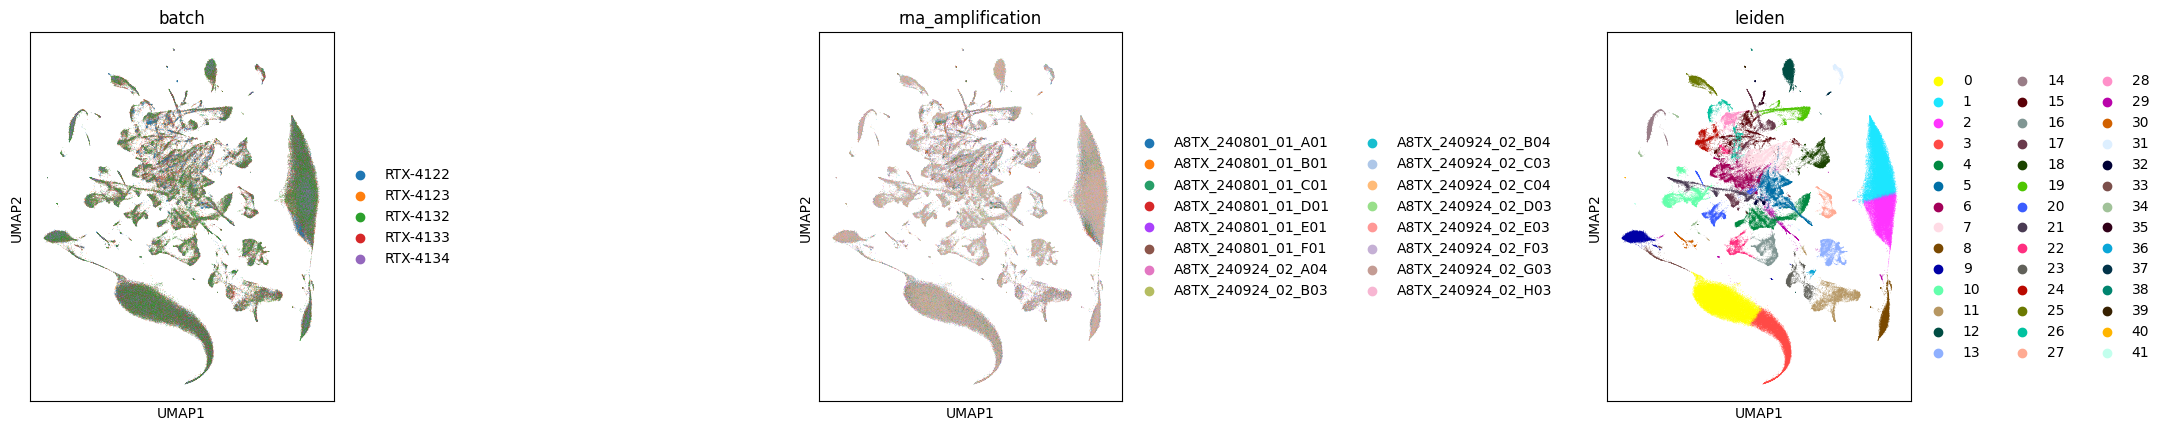

In [57]:
ax = sc.pl.umap(filtered_adata, color=["batch","rna_amplification","leiden"], wspace=0.4, show=False)
for a in ax: a.set_aspect('equal')


# 3. cluster to find the populations

/home/shuonan.chen/miniconda3/envs/allensdk/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


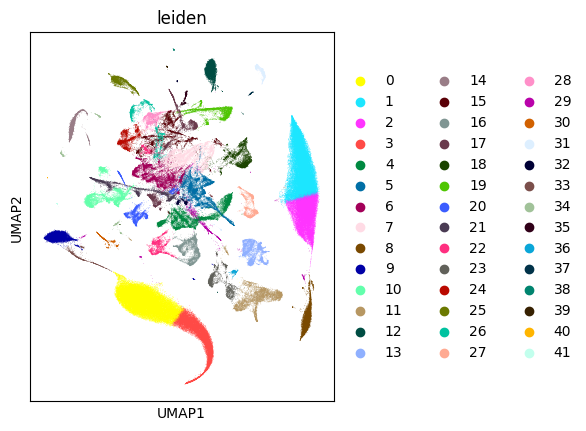

In [58]:
a = sc.pl.umap(filtered_adata, color=["leiden"], show = False)
a.set_aspect('equal')

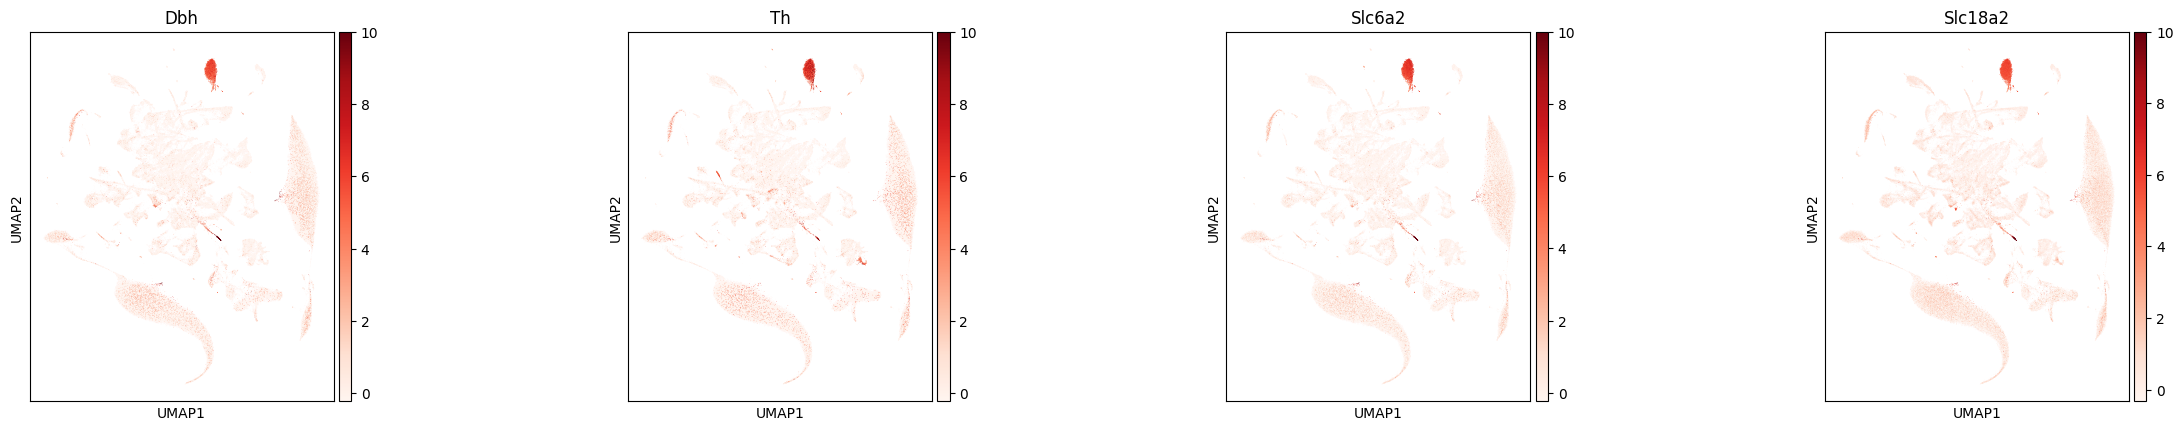

In [59]:
ax = sc.pl.umap(filtered_adata, color=['Dbh','Th','Slc6a2','Slc18a2'], 
                ncols=4, cmap = 'Reds',show = False)
for a in ax: a.set_aspect('equal')

## here choose the cluster from the plot. 
alternatively automatically choose the cluster which express all the markers (TODO)

In [60]:
selected_cluster = '12'

/home/shuonan.chen/miniconda3/envs/allensdk/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


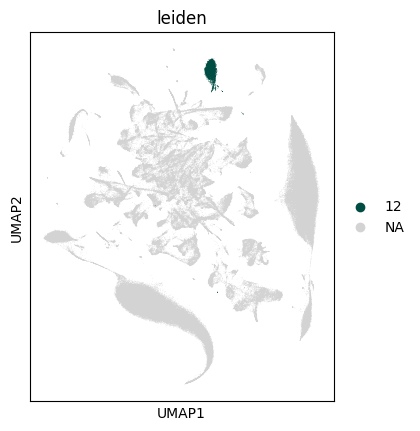

In [61]:
a=sc.pl.umap(filtered_adata, color='leiden', groups=[selected_cluster], show = False)
a.set_aspect("equal")

# save the results for mapmycell

# load the results and re-plot them 

In [62]:
import glob
savepath = '/home/shuonan.chen/scratch_shuonan/LC_scRNAseq/tempfiles/snRNA_ALL_LC_mapmycell/'
filenames = glob.glob(savepath+'*.csv')
filenames

['/home/shuonan.chen/scratch_shuonan/LC_scRNAseq/tempfiles/snRNA_ALL_LC_mapmycell/bigdata1_for_mapmycell_1_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1756261792551.csv',
 '/home/shuonan.chen/scratch_shuonan/LC_scRNAseq/tempfiles/snRNA_ALL_LC_mapmycell/bigdata1_for_mapmycell_2_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1756262245214.csv']

In [63]:
## use the following to confirm that we want to skip the first 4 rows
# cat  'bigdata1_for_mapmycell_1_10xWholeMouseBrain(CCN20230722)_HierarchicalMapping_UTC_1756261792551.csv' | head -n 4

df1 = pd.read_csv(filenames[0],skiprows=[0,1,2,3])
df2 = pd.read_csv(filenames[1],skiprows=[0,1,2,3])

df = pd.concat([df1, df2], axis=0)
df = df.set_index("cell_id")
df = df.reindex(filtered_adata.obs_names)
filtered_adata.obs = pd.concat([filtered_adata.obs, df], axis=1)

In [64]:
df1.head()

cell_id         class_label  \
0  AAACCAAAGAACGGCA-L8TX_240808_02_A05-NW-TX4122-4  CS20230722_CLAS_30   
1  AAACCAAAGCAACCCG-L8TX_240808_02_A05-NW-TX4122-4  CS20230722_CLAS_31   
2  AAACCAAAGCCATAGC-L8TX_240808_02_A05-NW-TX4122-4  CS20230722_CLAS_30   
3  AAACCAAAGGATAGCG-L8TX_240808_02_A05-NW-TX4122-4  CS20230722_CLAS_30   
4  AAACCAAAGGCATCCG-L8TX_240808_02_A05-NW-TX4122-4  CS20230722_CLAS_31   

      class_name  class_bootstrapping_probability       subclass_label  \
0  30 Astro-Epen                              1.0  CS20230722_SUBC_318   
1   31 OPC-Oligo                              1.0  CS20230722_SUBC_327   
2  30 Astro-Epen                              1.0  CS20230722_SUBC_318   
3  30 Astro-Epen                              1.0  CS20230722_SUBC_318   
4   31 OPC-Oligo                              1.0  CS20230722_SUBC_327   

     subclass_name  subclass_bootstrapping_probability       supertype_label  \
0  318 Astro-NT NN                                 1.0  CS20230722_SUPT_1159   
1     327 Oligo NN                                 1.0  CS20230722_SUPT_1184   
2  318 Astro-NT NN                                 1.0  CS20230722_SUPT_1160   
3  318 Astro-NT NN                                 1.0  CS20230722_SUPT_1160   
4     327 Oligo NN                                 1.0  CS20230722_SUPT_1184   

       supertype_name  supertype_bootstrapping_probability  \
0  1159 Astro-NT NN_1                                  1.0   
1       1184 MOL NN_4                                  1.0   
2  1160 Astro-NT NN_2                                  1.0   
3  1160 Astro-NT NN_2                                  1.0   
4       1184 MOL NN_4                                  1.0   

          cluster_label        cluster_name  cluster_alias  \
0  CS20230722_CLUS_5212  5212 Astro-NT NN_1          14977   
1  CS20230722_CLUS_5286       5286 MOL NN_4           5232   
2  CS20230722_CLUS_5216  5216 Astro-NT NN_2          14965   
3  CS20230722_CLUS_5214  5214 Astro-NT NN_2          14956   
4  CS20230722_CLUS_5285       5285 MOL NN_4           5231   

   cluster_bootstrapping_probability  
0                               0.84  
1                               0.96  
2                               0.97  
3                               1.00  
4                               1.00

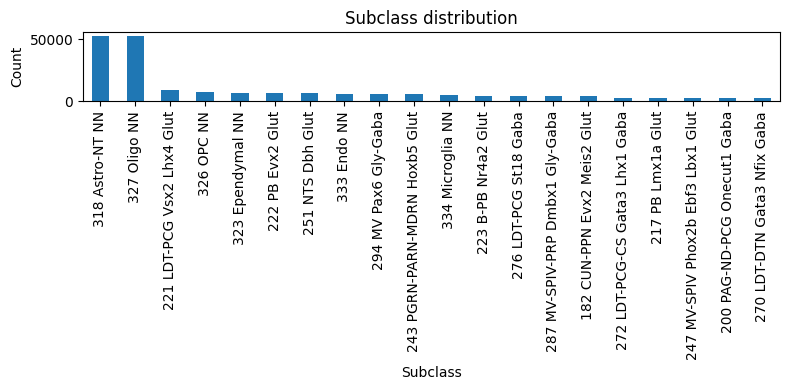

In [65]:
counts = df["subclass_name"].value_counts()[:20]

counts.plot(kind="bar", figsize=(8,4))
plt.ylabel("Count")
plt.xlabel("Subclass")
plt.title("Subclass distribution")
plt.tight_layout()
plt.show()

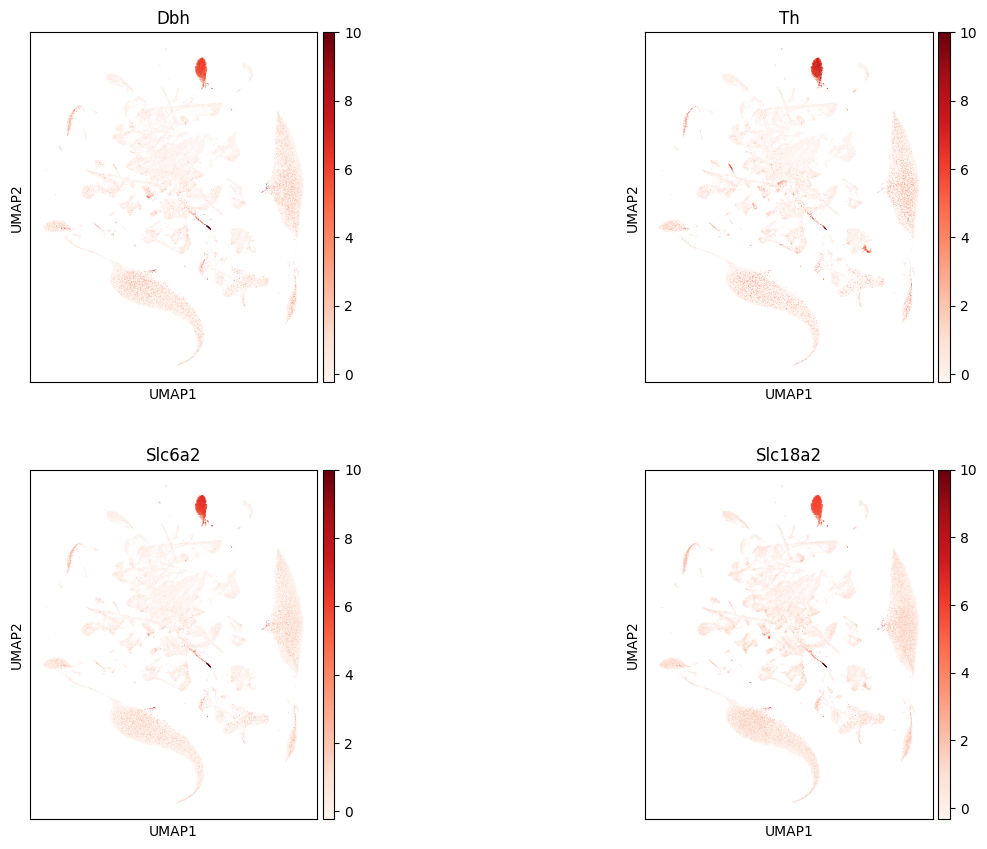

In [66]:
ax = sc.pl.umap(filtered_adata, color=['Dbh','Th','Slc6a2','Slc18a2'], 
                ncols=2, cmap = 'Reds',show = False)
for a in ax: a.set_aspect('equal')

# map the subclass 

/home/shuonan.chen/miniconda3/envs/allensdk/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/shuonan.chen/miniconda3/envs/allensdk/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


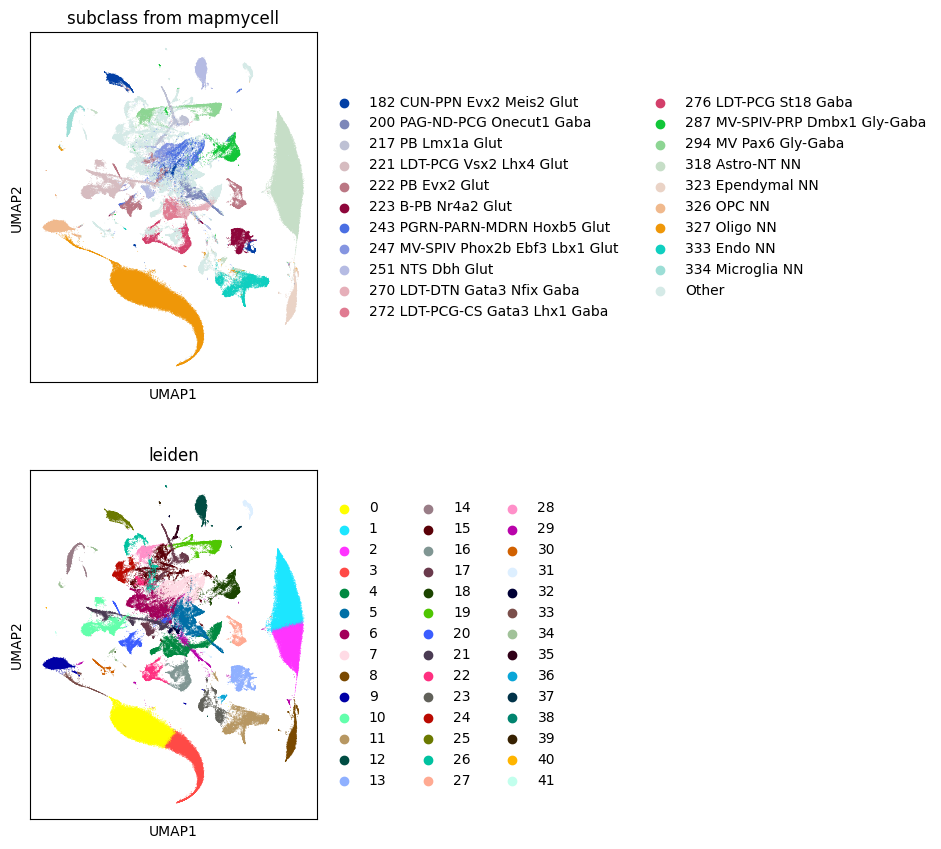

In [67]:
T = 30
topT = counts.index[:T]
filtered_adata.obs["subclass_name_topT"] = [
    x if x in topT else "Other" 
    for x in filtered_adata.obs["subclass_name"]
]

ax = sc.pl.umap(
    filtered_adata,  color=["subclass_name_topT",'leiden'],
    size=1,show = False,ncols=1, 
#     legend_loc="on data"
)
ax[0].set_title('subclass from mapmycell')
for a in ax: a.set_aspect('equal')

In [68]:
filtered_adata.obs[["subclass_name_topT",'leiden']].value_counts()[:10]

subclass_name_topT          leiden
327 Oligo NN                0         35455
318 Astro-NT NN             1         32499
                            2         19563
327 Oligo NN                3         15812
326 OPC NN                  9          7018
323 Ependymal NN            8          6997
221 LDT-PCG Vsx2 Lhx4 Glut  10         5877
Other                       6          5487
333 Endo NN                 11         5446
Other                       5          5190
dtype: int64

In [69]:
filtered_adata.obs[['leiden','subclass_name_topT']].value_counts()[:10]

leiden  subclass_name_topT        
0       327 Oligo NN                  35455
1       318 Astro-NT NN               32499
2       318 Astro-NT NN               19563
3       327 Oligo NN                  15812
9       326 OPC NN                     7018
8       323 Ependymal NN               6997
10      221 LDT-PCG Vsx2 Lhx4 Glut     5877
6       Other                          5487
11      333 Endo NN                    5446
5       Other                          5190
dtype: int64

In [70]:
np.unique(filtered_adata[filtered_adata.obs['subclass_name_topT']=='251 NTS Dbh Glut'].obs['leiden'], return_counts = True)

(array(['0', '11', '12', '17', '20', '23', '29', '34', '5', '6', '8'],
       dtype=object),
 array([   1,    5, 5060, 1310,    1,    2,  281,    3,    1,    4,    1]))

In [71]:
np.unique(filtered_adata[filtered_adata.obs['leiden']==selected_cluster].obs['subclass_name_topT'], return_counts = True)

(array(['217 PB Lmx1a Glut', '222 PB Evx2 Glut', '223 B-PB Nr4a2 Glut',
        '243 PGRN-PARN-MDRN Hoxb5 Glut', '251 NTS Dbh Glut',
        '294 MV Pax6 Gly-Gaba', '318 Astro-NT NN', 'Other'], dtype=object),
 array([   1,    1,    2,    5, 5060,    1,    1,    9]))

In [80]:
filtered_adata[filtered_adata.obs['leiden']==selected_cluster].shape

(5080, 1500)

# then re-clusteirng 

In [81]:
adata_subcls = filtered_adata[filtered_adata.obs['leiden']==selected_cluster]
adata_subcls.shape

(5080, 1500)

In [82]:
sc.tl.pca(adata_subcls)
sc.pp.neighbors(adata_subcls)
sc.tl.umap(adata_subcls)
sc.tl.leiden(adata_subcls, resolution = .5)
adata_subcls.shape

(5080, 1500)

In [83]:
adata_subcls.shape

(5080, 1500)

/home/shuonan.chen/miniconda3/envs/allensdk/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/shuonan.chen/miniconda3/envs/allensdk/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/shuonan.chen/miniconda3/envs/allensdk/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


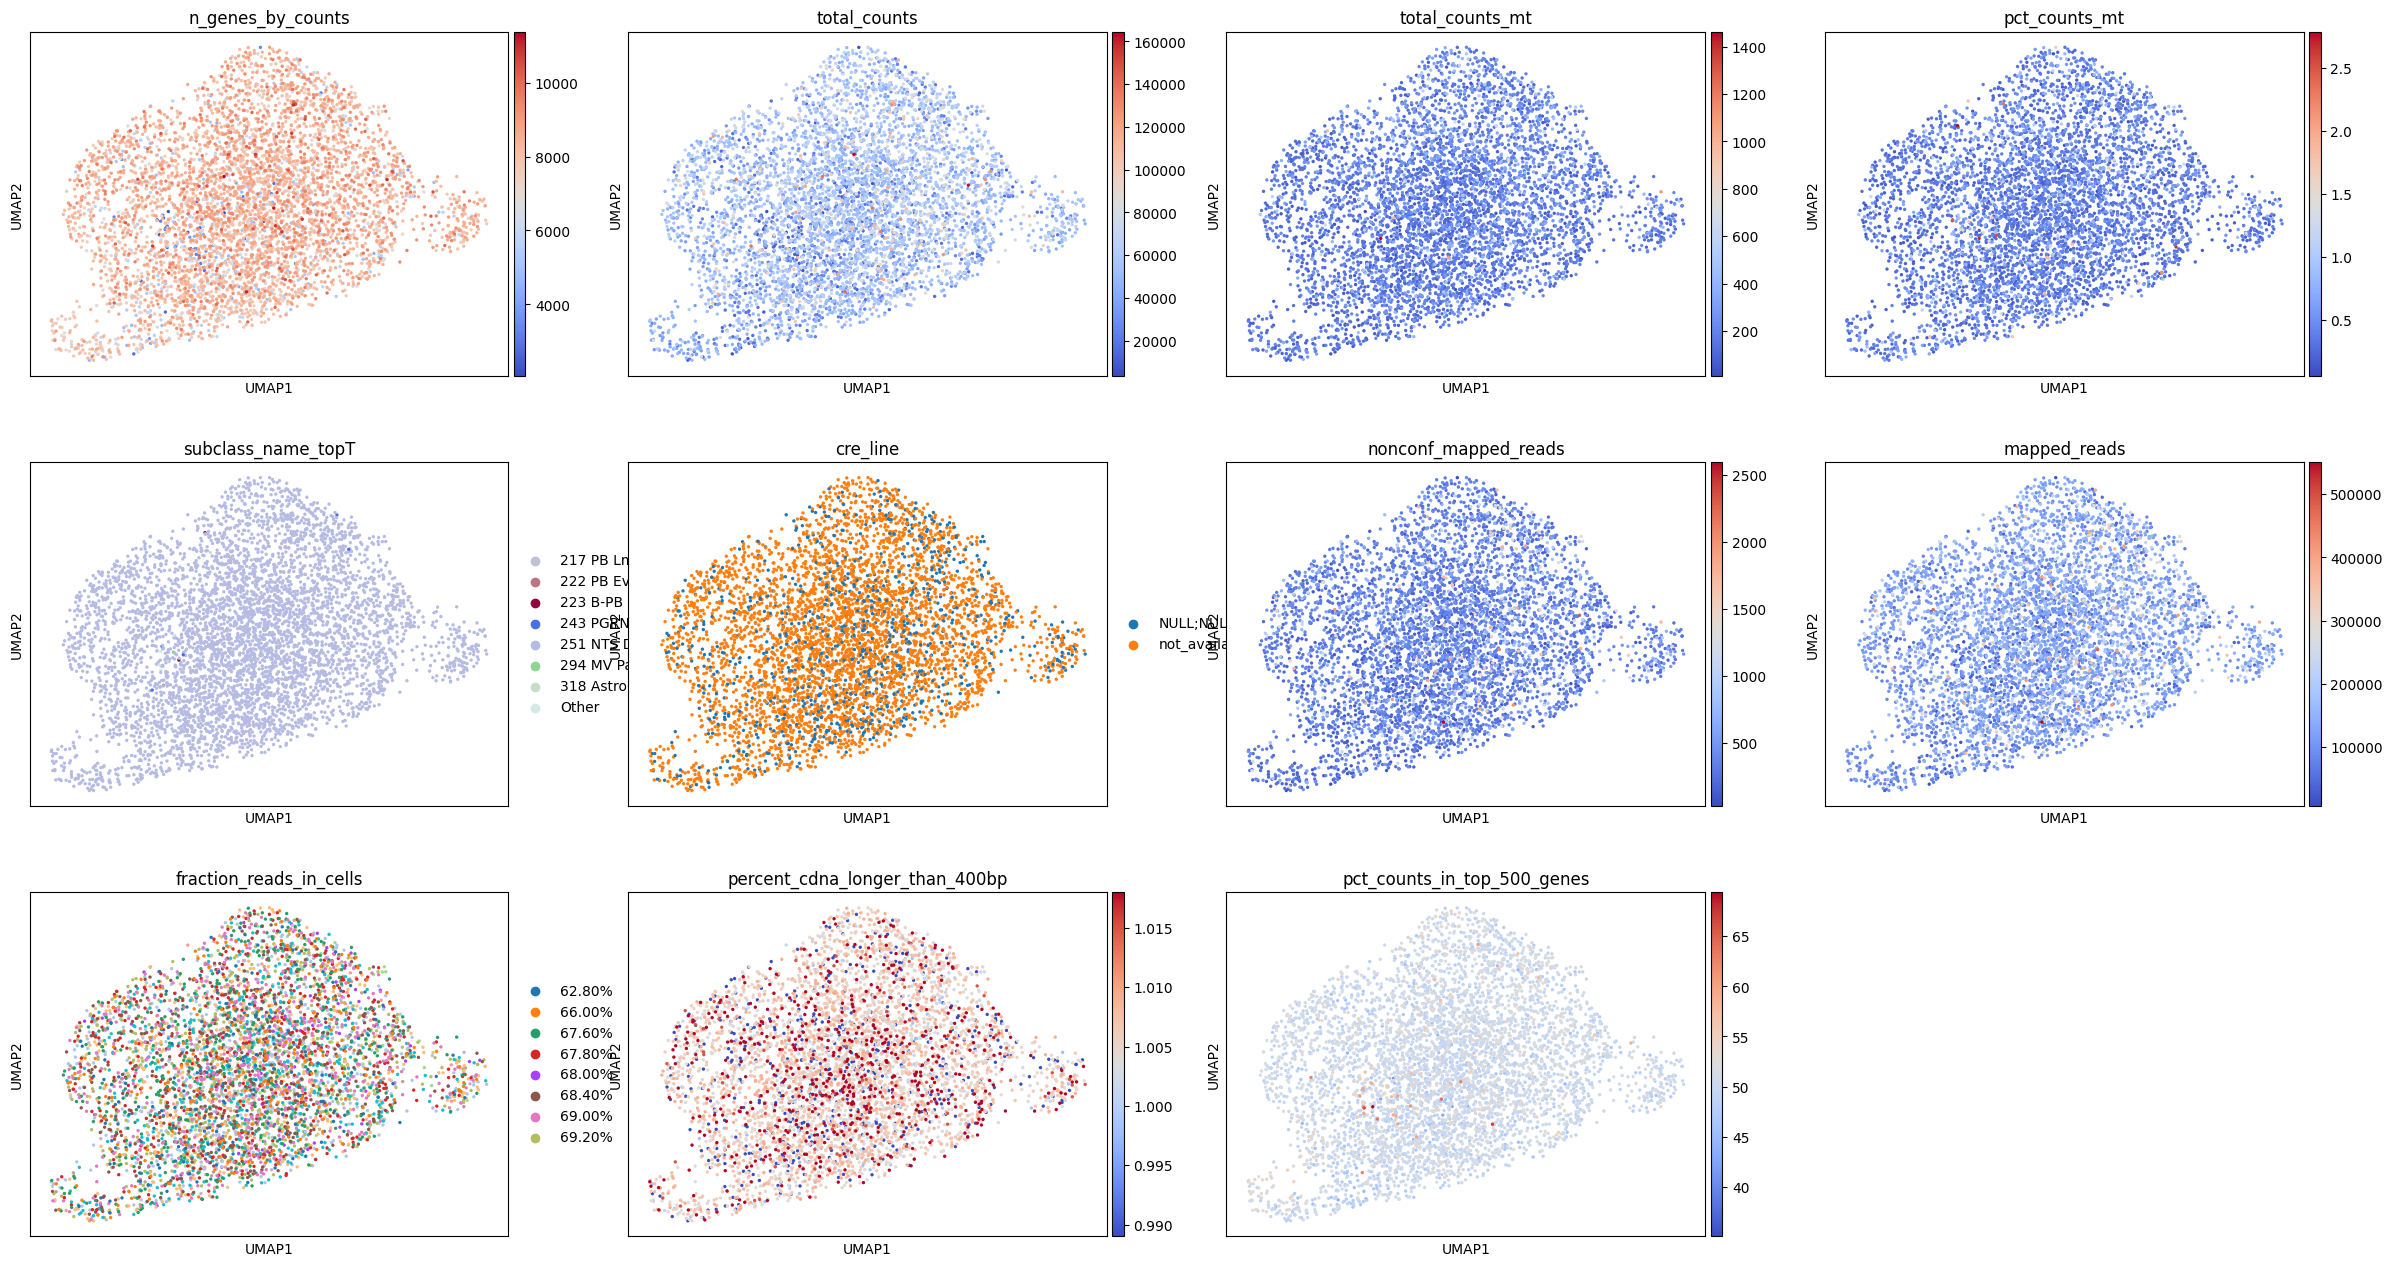

In [84]:
collist = ['n_genes_by_counts','total_counts','total_counts_mt',
           'pct_counts_mt','subclass_name_topT','cre_line','nonconf_mapped_reads','mapped_reads',
           'fraction_reads_in_cells','percent_cdna_longer_than_400bp','pct_counts_in_top_500_genes'
          ]

ax = sc.pl.umap(adata_subcls,color=collist, cmap = 'coolwarm')
for a in ax: a.set_aspect('equal')

/home/shuonan.chen/miniconda3/envs/allensdk/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


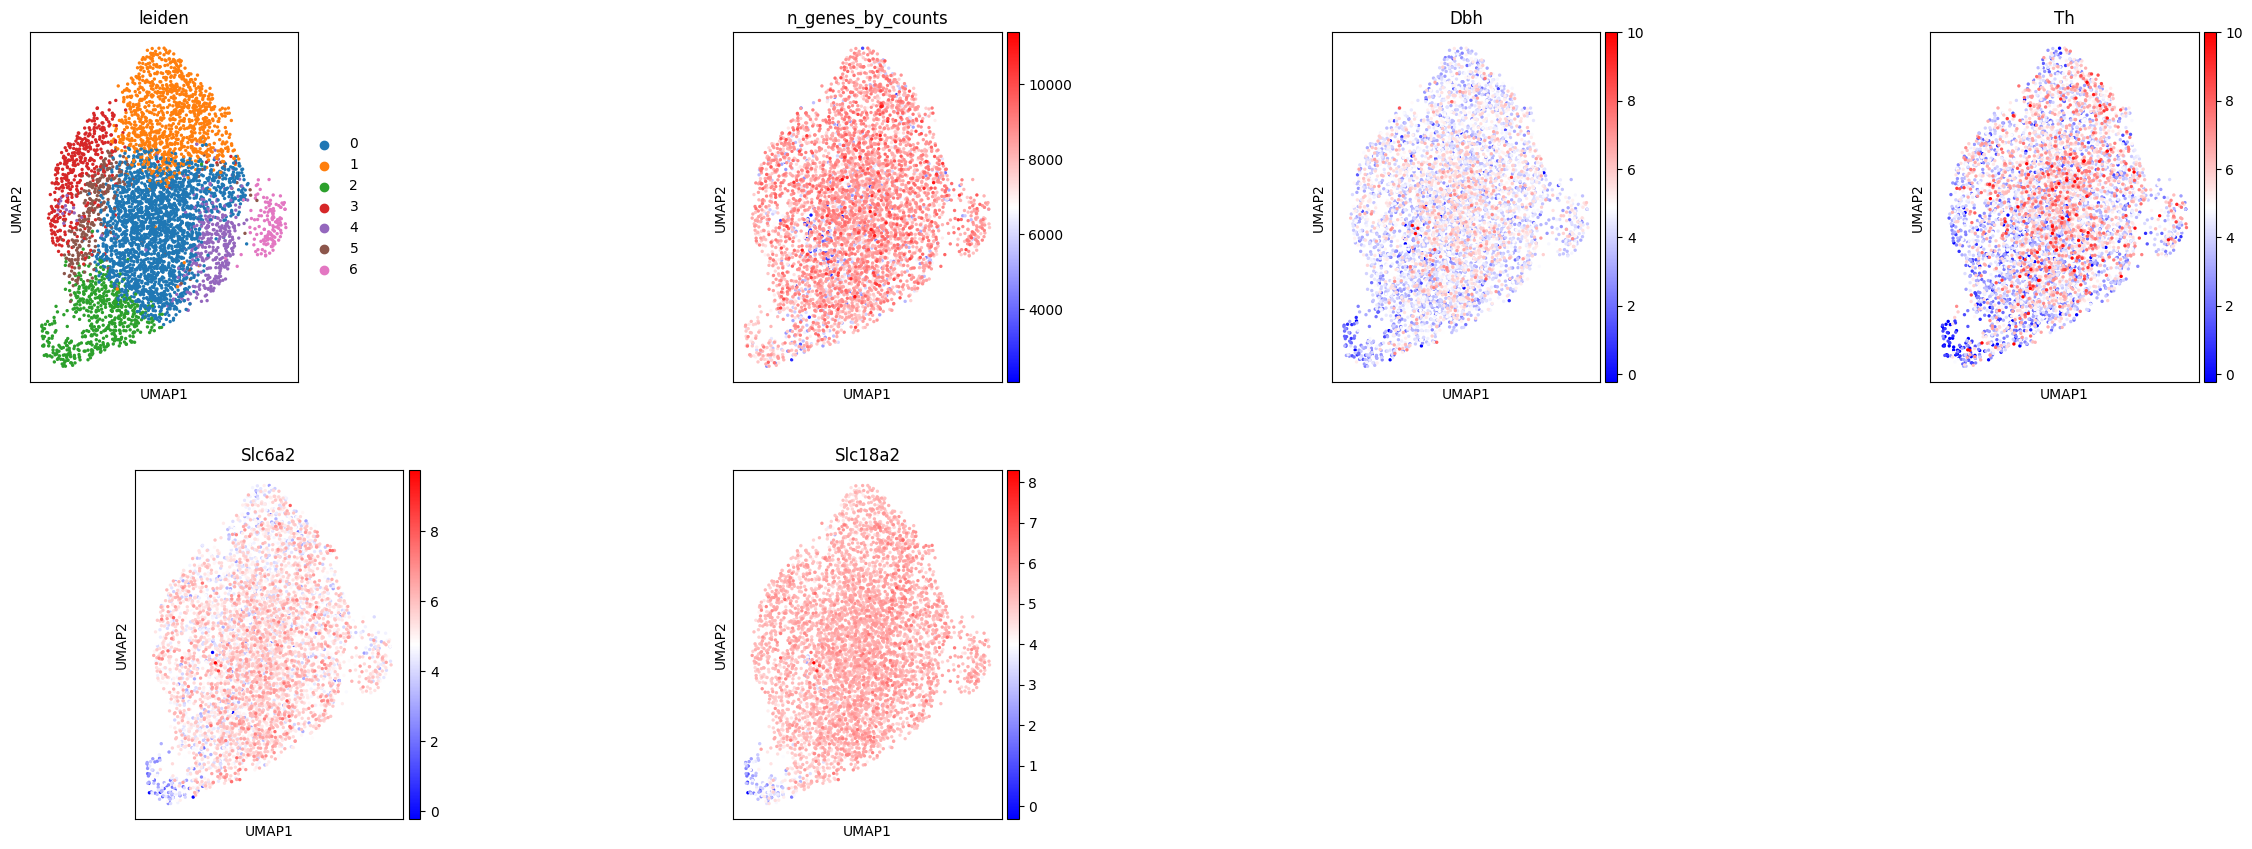

In [85]:
ax = sc.pl.umap(adata_subcls,ncols=4, color=['leiden','n_genes_by_counts','Dbh','Th','Slc6a2','Slc18a2'], 
                cmap = 'bwr', show = False)
for a in ax: a.set_aspect('equal')

In [92]:
(adata_subcls[:,'Dbh'].X>2).sum()

4901

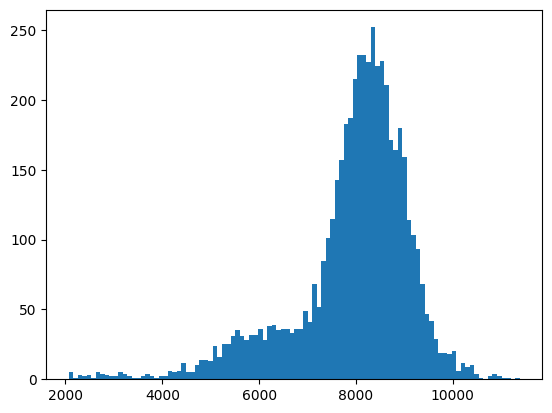

In [86]:
plt.hist(adata_subcls.obs['n_genes_by_counts'], bins = 100);


In [87]:
(adata_subcls.obs['n_genes_by_counts']>4000).sum()

5025

In [35]:
adata_subcls[adata_subcls.obs['leiden']!='4' ].shape

(4291, 5000)

In [36]:
((adata_subcls.obs['leiden']!='4') & (adata_subcls.obs['leiden']!='7' )).sum()

4291

### outdated

In [30]:
sc.pp.normalize_total(filtered_adata)
sc.pp.log1p(filtered_adata)

/home/shuonan.chen/miniconda3/envs/allensdk/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [31]:
sc.pp.highly_variable_genes(filtered_adata, n_top_genes=5000, subset = True)

In [32]:
sc.tl.pca(filtered_adata)
sc.pp.neighbors(filtered_adata)
sc.tl.umap(filtered_adata)
sc.tl.leiden(filtered_adata, resolution = 0.5)

/home/shuonan.chen/miniconda3/envs/allensdk/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


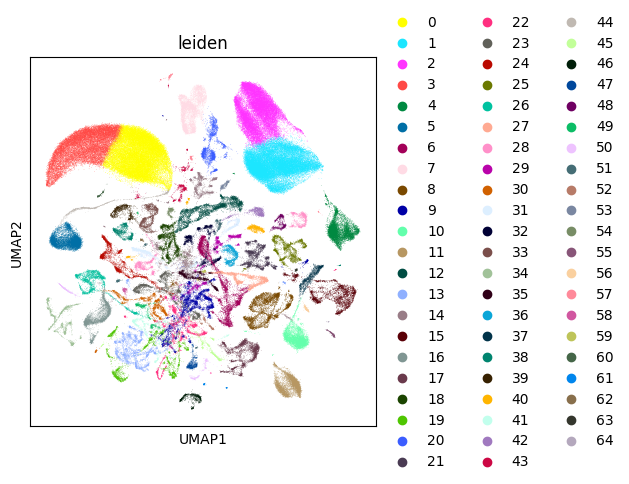

In [35]:
a = sc.pl.umap(filtered_adata, color=["leiden"], show = False)
a.set_aspect('equal')